![AIcrowd-Logo](https://raw.githubusercontent.com/AIcrowd/AIcrowd/master/app/assets/images/misc/aicrowd-horizontal.png)

# Baseline for [SNAKE Challenge](https://www.aicrowd.com/challenges/snake) on AIcrowd
#### Author : Gauransh Kumar

## Download Necessary Packages

In [1]:
import sys
!{sys.executable} -m pip install aicrowd-cli
%load_ext aicrowd.magic

     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 214 kB 48.8 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.4 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 170 kB 75.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 51 kB 9.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 22.3.0
    Uninstalling pyzmq-22.3.0:
      Successfully uninstalled pyzmq-22.3.0
  Attempting uninstall: python-slugify
    Found existing installation: python-slugify 6.0.1
    Uninstalling python-slugify-6.0.1:
      Successfully uninstalled python-slugify-6.0.1
ERROR: pip's dependency resolver does not curren

## Dataset Download



In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/TraUJtGc2DwnKXGLcxPZgwvOwWSl1Bh7v9pWBNVv7ik
API Key valid
Gitlab access token valid
Saved details successfully!


In [4]:
%aicrowd ds dl -c snake

test.zip:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/201M [00:00<?, ?B/s]

sample_submission.csv:   0%|          | 0.00/522k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/1.81G [00:00<?, ?B/s]

In [5]:
# creating 
!mkdir data
!mkdir data/test
!mkdir data/train
!mkdir data/val

In [6]:
# Unzipping the images
!unzip -q train.zip
!unzip -q test.zip
!unzip -q val.zip

In [7]:
!mv content/data/train/* data/train
!mv content/data/val/* data/val
!mv content/data/test/* data/test

In [8]:
!rm -rf content/

In [9]:
!mkdir models

## Imports

In [80]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [14]:
# checking tensorflow version and CUDA device
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.0
/device:GPU:0


## Model and Data Preprocessing

In [21]:
# constanst
train_dir = os.path.join("data", 'train')
validation_dir = os.path.join("data", 'val')
test_dir = os.path.join("data", 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)


In [18]:
# training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 53723 files belonging to 2 classes.


In [22]:
# validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 5967 files belonging to 2 classes.


In [53]:
# training dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           labels=None,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 14927 files belonging to 1 classes.


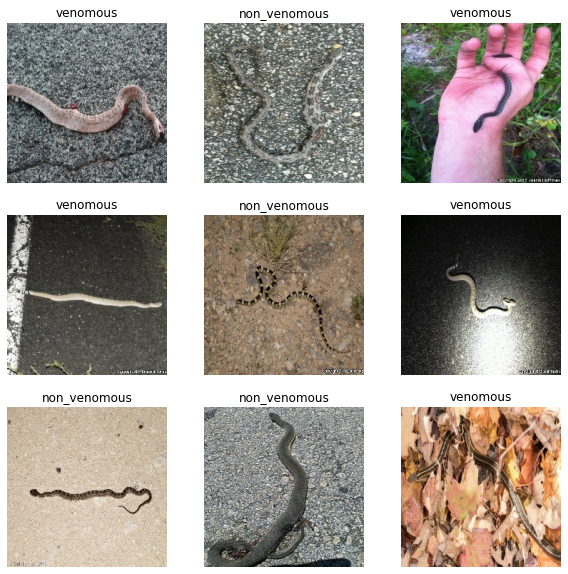

In [23]:
# plotting some images from the Dataset
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
# fine tuning for perforamnce
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [27]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [29]:
# Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [30]:
# Applying a pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Applying a dense layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


In [33]:
# Building the final model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# learning rate can be tweeked for better accuracy
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

## Training

In [38]:
initial_epochs = 2

loss0, accuracy0 = model.evaluate(validation_dataset)

187/187 [==============================] - 9s 46ms/step - loss: 0.9288 - accuracy: 0.4463


In [39]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.93
initial accuracy: 0.45


In [40]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/2
1679/1679 [==============================] - 99s 57ms/step - loss: 0.7064 - accuracy: 0.6844 - val_loss: 0.5983 - val_accuracy: 0.7086
Epoch 2/2
1679/1679 [==============================] - 87s 51ms/step - loss: 0.7144 - accuracy: 0.6867 - val_loss: 0.5964 - val_accuracy: 0.7183


In [ ]:
# initial accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# initial loss
loss = history.history['loss']
val_loss = history.history['val_loss']

### Fine Tuning

In [59]:
# fine tuning
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

Number of layers in the base model:  154


In [60]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [61]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 2/4
1679/1679 [==============================] - 131s 74ms/step - loss: 0.8775 - accuracy: 0.5363 - val_loss: 0.6885 - val_accuracy: 0.5557
Epoch 3/4
1679/1679 [==============================] - 125s 74ms/step - loss: 0.7066 - accuracy: 0.5518 - val_loss: 0.6872 - val_accuracy: 0.5557
Epoch 4/4
1679/1679 [==============================] - 124s 74ms/step - loss: 0.7054 - accuracy: 0.5512 - val_loss: 0.6933 - val_accuracy: 0.5557


In [62]:
# storing the model for future use
model.save("models/mobilenet_baseline")

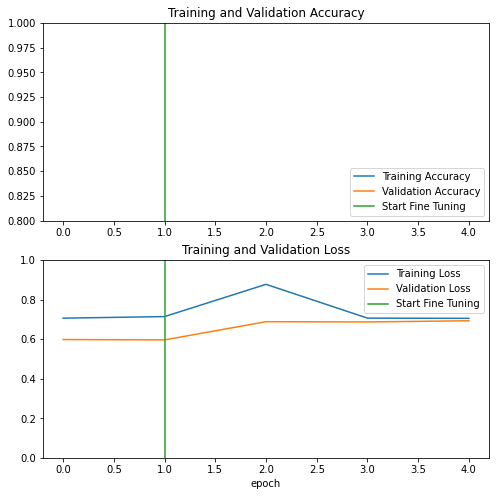

In [63]:
# plotting the learning curve
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Prediction

In [101]:
def make_submission_csv(model, name):    
    images = []
    prediction = []
    probability = []
    test_path = "data/test/"
    test = pd.read_csv("sample_submission.csv")
    test_files = os.listdir(test_path)
    test_files = [x.split(".jpg")[0] for x in test_files]
    test = test.loc[test["id"].isin(test_files)]
    files = test["id"]
    files = [x + ".jpg" for x in files]
    for i in tqdm(files):
        images.append(i.split(".")[0])
        # reading images and converting to np array
        img  = tf.keras.utils.load_img(os.path.join(test_path, i), target_size = IMG_SIZE)
        img = tf.keras.utils.img_to_array(img)

        # predicting the class
        pred = model.predict(img[None,...])

        # Apply a sigmoid since our model returns logits
        pred = tf.nn.sigmoid(pred)
        pred = tf.where(pred < 0.5, 0, 1)

        # some flattening and slicing to get the predicted class and finally getting the label
        pred_class = class_names[pred.numpy().flatten()[0]]
        prediction.append(pred_class)

    answer = pd.DataFrame({'id': images, 'class': prediction})
    display(answer.head())
    answer.to_csv(name, index=False)

In [102]:
make_submission_csv(model, "submission.csv")

100%|██████████| 14927/14927 [11:59<00:00, 20.75it/s]


id     class
0  00022e97c90898c02a25579be  venomous
1  000816b96db153cc47dfb79db  venomous
2  001d2fe5ca243c138472d130b  venomous
3  001e3329abba16fb91ee4d47f  venomous
4  0026cf1ed9556341340419b19  venomous

## Make a submission using the aicrwd-cli

In [103]:
!aicrowd submission create -c snake -f submission.csv

submission.csv ━━━━━━━━━━━━━━━━━━ 100.0% • 524.1/522.5 KB • 871.9 kB/s • 0:00:00
                                                  ╭─────────────────────────╮                                                  
                                                  │ Successfully submitted! │                                                  
                                                  ╰─────────────────────────╯                                                  
                                                        Important links                                                        
┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-for-good-ai-blitz-3/problems/snake/submissions/176108              │
│                  │                                                                                                          │
│  All submissions │ ht